In [1]:
import pandas as pd

1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

In [3]:
file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name)
print(f"Here is the dataframe from data_000637.txt that we will use for this exercise : \n{data}")

Here is the dataframe from data_000637.txt that we will use for this exercise : 
         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0           1     0          123  3869200167        2374        26
1           1     0          124  3869200167        2374        27
2           1     0           63  3869200167        2553        28
3           1     0           64  3869200167        2558        19
4           1     0           64  3869200167        2760        25
...       ...   ...          ...         ...         ...       ...
1310715     1     0           62  3869211171         762        14
1310716     1     1            4  3869211171         763        11
1310717     1     0           64  3869211171         764         0
1310718     1     0          139  3869211171         769         0
1310719     1     0           61  3869211171         762        18

[1310720 rows x 6 columns]


1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [4]:
def N_row(data, N) :
    if N < 10000 : 
        raise ValueError(f"Error : N must be > 10000 (here N = {N})")
    elif N > data.shape[0] :
        raise ValueError(f"Error : N must be < {data.shape[0]}")
    else :
        return data[:N]
    
N = 100000
data_N = N_row(data, N)

print(f"""We take N = {N}.\n
=> For the DataFrame that reads the first N rows of data/data_000637.txt dataset, we obtain the following dataframe: \n{data_N}\n\n
=> By using .tail() on the dataframe and knowing that we have N = {N}, we can see that the dataframe reads the N lines: \n{data_N.tail()}
""")

We take N = 100000.

=> For the DataFrame that reads the first N rows of data/data_000637.txt dataset, we obtain the following dataframe: 
       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
99995     1     0           64  3869201161        2378        29
99996     1     0           70  3869201161        2472        26
99997     1     0           58  3869201161        2558         0
99998     1     0           57  3869201161        2561        23
99999     1     0           56  3869201161        2565        12

[100000 rows x 6 columns]


=> By using .tail() on the dataframe and knowing tha

2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [5]:
x = data['BX_COUNTER'].max()

print(f"The estimate number of BX in a ORBIT is : {x}")

The estimate number of BX in a ORBIT is : 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [6]:
# Initialization
TDC_time = 25/30                      # Each TDC count corresponds to 25/30 ns
BX_COUNTER_time = 25                  # Each BX_COUNTER unit corresponds to 25 ns
ORBIT_CNT_time = BX_COUNTER_time * x  # The ORBIT_CNT is increased every 'x' BX_COUNTER

# For each line, we add in a new ABSOLUTE_TIME column, the absolute time in ns calculated
data['ABSOLUTE_TIME'] = data['TDC_MEAS'] * TDC_time + data['BX_COUNTER'] * BX_COUNTER_time + data['ORBIT_CNT'] * ORBIT_CNT_time

# We set up the offset to ensure that the time starts at 0
data['ABSOLUTE_TIME'] -= data['ABSOLUTE_TIME'][0]

data['ABSOLUTE_TIME'] = pd.to_datetime(data['ABSOLUTE_TIME'])

print(f"Here is the updated dataset with the new ABSOLUTE_TIME column : \n{data}")

Here is the updated dataset with the new ABSOLUTE_TIME column : 
         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0           1     0          123  3869200167        2374        26   
1           1     0          124  3869200167        2374        27   
2           1     0           63  3869200167        2553        28   
3           1     0           64  3869200167        2558        19   
4           1     0           64  3869200167        2760        25   
...       ...   ...          ...         ...         ...       ...   
1310715     1     0           62  3869211171         762        14   
1310716     1     1            4  3869211171         763        11   
1310717     1     0           64  3869211171         764         0   
1310718     1     0          139  3869211171         769         0   
1310719     1     0           61  3869211171         762        18   

                        ABSOLUTE_TIME  
0       1970-01-01 00:00:00.000000000  
1       1970-0

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [7]:
# To get the duration, we subtract the time of the first entry from that of the last entry
duration = data['ABSOLUTE_TIME'].iloc[-1] - data['ABSOLUTE_TIME'].iloc[0]

# Extract hours, minutes, and seconds from the duration
hours = duration.components.hours
minutes = duration.components.minutes
seconds = duration.components.seconds
milliseconds = duration.components.milliseconds
microseconds = duration.components.microseconds
nanoseconds = duration.components.nanoseconds

# We display hours, minutes, and seconds
print(f"The final duration obtained corresponds to : {hours} h {minutes} m {seconds},{milliseconds}.{microseconds}.{nanoseconds} s")


The final duration obtained corresponds to : 0 h 0 m 0,980.140.993 s


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [8]:
# We groupby according to 'TDC_CHANNEL', then we count the number of occurrences for each channel, and we sort in descending order
noisy_channels = data.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count().sort_values(ascending=False)

print(f"Top 3 of TDC channels with most counts : \n{noisy_channels.head(3)}")

Top 3 of TDC channels with most counts : 
TDC_CHANNEL
139    108059
64      66020
63      64642
Name: TDC_CHANNEL, dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [9]:
# We count the number of groups based on the unique values of 'ORBIT_CNT'
non_empty_orbits = len(data.groupby('ORBIT_CNT'))

print(f"We have {non_empty_orbits} non-empty orbits")

We have 11001 non-empty orbits


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [10]:
# We filter for TDC_CHANNEL=139
data_channel139 = data[data['TDC_CHANNEL'] == 139]

# We count the number of groups based on the unique values of 'ORBIT_CNT' of the DataFrame for TDC_CHANNEL=139 
unique_orbits_with_139 = len(data_channel139.groupby('ORBIT_CNT'))

print(f"We have {unique_orbits_with_139} unique orbits with at least one measurement from TDC_CHANNEL=139")

We have 10976 unique orbits with at least one measurement from TDC_CHANNEL=139


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [11]:
# Filtering for each FPGA
FPGA0 = data[data['FPGA'] == 0]
FPGA1 = data[data['FPGA'] == 1]

# We groupby according to TDC_CHANNEL, then we count for each FPGA
TDC_CHANNEL_FPGA0 = FPGA0.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
TDC_CHANNEL_FPGA1 = FPGA1.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()

print(f"For FPGA 0, we have : \n{TDC_CHANNEL_FPGA0}\n\n")
print(f"For FPGA 1, we have : \n{TDC_CHANNEL_FPGA1}")

For FPGA 0, we have : 
TDC_CHANNEL
1       1215
2       1602
3       1493
4       2352
5       1432
       ...  
129        2
130       33
137       32
138       34
139    75617
Name: TDC_CHANNEL, Length: 124, dtype: int64


For FPGA 1, we have : 
TDC_CHANNEL
1      28438
2      32669
3      21970
4      26403
5      15003
       ...  
129       35
130       38
137       36
138       36
139    32442
Name: TDC_CHANNEL, Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

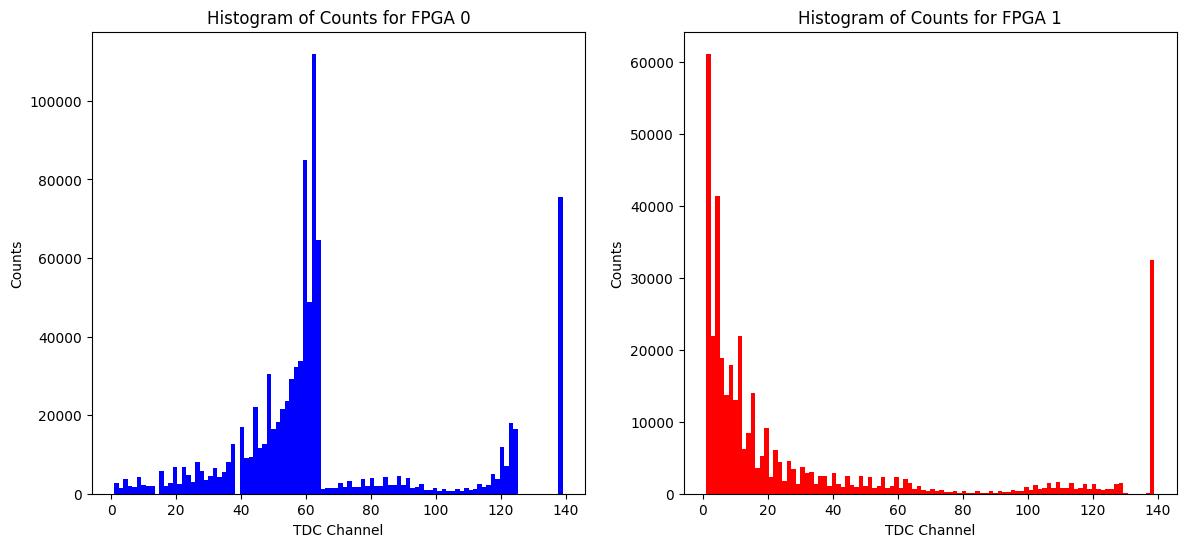

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# For FPGA 0
plt.subplot(1, 2, 1)
plt.hist(FPGA0['TDC_CHANNEL'], bins=100, color='b')
plt.title('Histogram of Counts for FPGA 0')
plt.xlabel('TDC Channel')
plt.ylabel('Counts')

# For FPGA 1
plt.subplot(1, 2, 2)
plt.hist(FPGA1['TDC_CHANNEL'], bins=100, color='r')
plt.title('Histogram of Counts for FPGA 1')
plt.xlabel('TDC Channel')
plt.ylabel('Counts')

plt.show()